In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.metrics import mean_squared_error
from pmdarima  import auto_arima
from datetime import datetime
import plotly.express as px
import plotly.offline as py
from scipy.stats import norm
from evds import evdsAPI
import ssl
from datetime import datetime
from scipy.stats import norm
from pandas.io import gbq
ssl._create_default_https_context = ssl._create_unverified_context
evds = evdsAPI('#########')

In [1]:
#getting an dollar-turkish lira dataset for last 3 years
df=evds.get_data(['TP.DK.USD.A.YTL'], startdate="01-01-2017", enddate='1-07-2020').fillna(method='ffill')
df['Tarih']=pd.to_datetime(df['Tarih'], format="%d-%m-%Y")
df=df.set_index(df['Tarih'])
df=df.dropna()
df.tail()

NameError: name 'evds' is not defined

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1277 entries, 2017-01-02 to 2020-07-01
Data columns (total 2 columns):
Tarih              1277 non-null datetime64[ns]
TP_DK_USD_A_YTL    1277 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 29.9 KB


In [186]:
#df['TP_DK_USD_A_YTL'].plot()
#fig = px.line(df, x=df.index, y='TP_DK_USD_A_YTL', title='usd-tl')
#fig.show()

In [187]:
f_sarima_model = auto_arima(df['TP_DK_USD_A_YTL'], trace = True, start_p = 0, d =0, start_q = 0,
                  max_p = 10, max_q = 10, m = 7, seasonal = True,
                  stepwise = True)
f_sarima_model.fit(df['TP_DK_USD_A_YTL'])
f_sarima_forecast = f_sarima_model.predict(n_periods= 30)
n_steps=30
idx = pd.date_range(df['TP_DK_USD_A_YTL'].index[-1], periods=n_steps,  freq='B')

forecast = f_sarima_model.predict(n_periods= 30) 
fc_all = pd.DataFrame(forecast,                     
                 index=idx, columns=['predicted'])

Performing stepwise search to minimize aic
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Fit ARIMA(0,0,0)x(1,0,1,7) [intercept=True]; AIC=-1476.979, BIC=-1456.370, Time=2.946 seconds
Fit ARIMA(0,0,0)x(0,0,0,7) [intercept=True]; AIC=3895.371, BIC=3905.675, Time=0.030 seconds
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Fit ARIMA(1,0,0)x(1,0,0,7) [intercept=True]; AIC=-3955.888, BIC=-3935.279, Time=1.758 seconds
Near non-invertible roots for order (1, 0, 0)(1, 0, 0, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,0,1)x(0,0,1,7) [intercept=True]; AIC=946.150, BIC=966.759, Time=1.606 seconds
Fit ARIMA(0,0,0)x(0,0,0,7) 

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1277 entries, 2017-01-02 to 2020-07-01
Data columns (total 2 columns):
Tarih              1277 non-null datetime64[ns]
TP_DK_USD_A_YTL    1277 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 29.9 KB


In [189]:
train=df['TP_DK_USD_A_YTL'].iloc[:1000]
test=df['TP_DK_USD_A_YTL'].iloc[1000:]

In [190]:
def monte_carlo_simulation(numeric_column, iterations, t_intervals):
    log_returns = np.log(1 + numeric_column.pct_change())
    u, var = log_returns.mean(), log_returns.var() #Mean of the logarithmich return
    drift = u - (0.5 * var) #drift / trend of the logarithmic return
    stdev = log_returns.std() #Standard deviation of the log return
    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))
    S0 = numeric_column.iloc[-1]
    price_list = np.zeros_like(daily_returns)
    price_list[0] = S0
    for t in range(1, t_intervals):
        price_list[t] = price_list[t - 1] * daily_returns[t]
    price_list = pd.DataFrame(price_list)
    price_list['close'] = price_list[0]
    close = numeric_column
    close = pd.DataFrame(close)
    frames = [close, price_list]
    monte_carlo_forecast = pd.concat(frames)
    monte_carlo = monte_carlo_forecast.iloc[:,:].values
    mcdf=pd.DataFrame(monte_carlo)
    mcdf['tot']=mcdf.sum(axis=1)/len(mcdf.columns)
    
    return pd.DataFrame(mcdf['tot'].dropna())
model_mc=monte_carlo_simulation(train, 50, len(test))


In [191]:
#model_mc=model_mc.dropna(how='all')
model_mc['real_val']=test
#model_mc[['tot', 'real_val']].iloc[1000:].plot()
model_mc

,tot,real_val
0,0.067677,NaN
1,0.067958,NaN
2,0.068725,NaN
3,0.068777,NaN
4,0.069104,NaN
...,...,...
1272,6.245320,NaN
1273,6.270411,NaN
1274,6.271987,NaN
1275,6.273678,NaN


In [192]:
test

Tarih
2019-09-29    5.6659
2019-09-30    5.6591
2019-10-01    5.6437
2019-10-02    5.6752
2019-10-03    5.7280
               ...  
2020-06-27    6.8434
2020-06-28    6.8434
2020-06-29    6.8417
2020-06-30    6.8422
2020-07-01    6.8432
Name: TP_DK_USD_A_YTL, Length: 277, dtype: float64

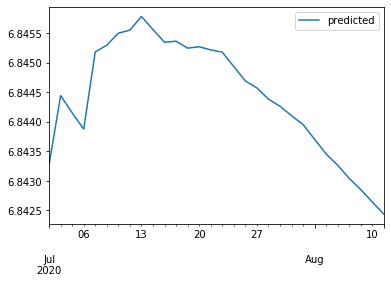

In [193]:
fc_all.plot()

In [194]:
n_steps=30
pd.date_range(df['Tarih'].values[-1], periods=n_steps,  freq='B')


DatetimeIndex(['2020-07-01', '2020-07-02', '2020-07-03', '2020-07-06',
               '2020-07-07', '2020-07-08', '2020-07-09', '2020-07-10',
               '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
               '2020-07-17', '2020-07-20', '2020-07-21', '2020-07-22',
               '2020-07-23', '2020-07-24', '2020-07-27', '2020-07-28',
               '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-03',
               '2020-08-04', '2020-08-05', '2020-08-06', '2020-08-07',
               '2020-08-10', '2020-08-11'],
              dtype='datetime64[ns]', freq='B')

In [195]:
df=gbq.read_gbq("""SELECT
  DATE(cdr.calldate) as date,
  AVG(cdr.waitduration) AS ortalama_bekleme,
  COUNT(DISTINCT cdr.callerid) AS arayan,
  AVG(cdr.duration) AS ortalama_konusma,
  COUNT(DISTINCT t1.aranan) AS out_aranan,
  AVG(t1.ortalama_konusma_out) AS ortalama_konusma_outbound,
  COUNT(distinct cdr.agent.username) as staff
FROM
  `musteri-hizmetleri.tapu_alo_tech_com.CDR` AS cdr
LEFT JOIN (
  SELECT
    calldate AS tarih,
    called_num AS aranan,
    duration AS ortalama_konusma_out
  FROM
    `musteri-hizmetleri.tapu_alo_tech_com.CDR`
  WHERE
    inbound=FALSE
    AND answered=TRUE) AS t1
ON
  DATE(cdr.calldate)=DATE(t1.tarih)
WHERE
  cdr.inbound=TRUE
  AND cdr.answered=TRUE
  AND cdr.initialqueue.name='Tapu_Devir'
GROUP BY

  DATE(cdr.calldate)""", project_id="symbolic-folio-257709")


Downloading: 100%|██████████| 791/791 [00:01<00:00, 748.03rows/s]


In [196]:
df['date']=pd.to_datetime(df['date'])
df=df.sort_values(by='date', ascending=True)
df=df.set_index(df['date'])
df['total']=df['arayan'] + df['out_aranan']
df['konuşma']=(df['ortalama_konusma'] + df['ortalama_konusma_outbound'])/2
df['avg_daily_talking_hour']=((df['total'] * df['konuşma'])/3600)/df['staff']
df['call_per_staff']=df['total']/df['staff']
df.head()

,date,ortalama_bekleme,arayan,ortalama_konusma,out_aranan,ortalama_konusma_outbound,staff,total,konuşma,avg_daily_talking_hour,call_per_staff
date,,,,,,,,,,,
2017-02-23,2017-02-23,8.500000,2,77.0,49,119.963636,1,51,98.481818,1.395159,51.0
2017-02-24,2017-02-24,281.666667,3,NaN,58,139.793651,0,61,NaN,NaN,inf
2017-02-28,2017-02-28,157.000000,2,117.0,94,140.240385,1,96,128.620192,3.429872,96.0
2017-03-01,2017-03-01,153.750000,4,116.0,70,149.923077,1,74,132.961538,2.733098,74.0
2017-03-02,2017-03-02,115.000000,1,NaN,86,134.444444,0,87,NaN,NaN,inf


In [197]:
f_sarima_model = auto_arima(df['total'], trace = True, start_p = 0, d =0, start_q = 0,
                  max_p = 10, max_q = 10, m = 7, seasonal = True,
                  stepwise = True)
f_sarima_model.fit(df['total'])
f_sarima_forecast = f_sarima_model.predict(n_periods= 30)
n_steps=30
idx = pd.date_range(df['total'].index[-1], periods=n_steps,  freq='B')

forecast = f_sarima_model.predict(n_periods= 30) 
fc_all = pd.DataFrame(forecast,                     
                 index=idx, columns=['predicted'])
fc_all['expected_staff']=fc_all['predicted']/60

Performing stepwise search to minimize aic
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

Fit ARIMA(0,0,0)x(1,0,1,7) [intercept=True]; AIC=8172.030, BIC=8190.724, Time=0.956 seconds
Fit ARIMA(0,0,0)x(0,0,0,7) [intercept=True]; AIC=8887.770, BIC=8897.117, Time=0.038 seconds
Fit ARIMA(1,0,0)x(1,0,0,7) [intercept=True]; AIC=8119.539, BIC=8138.232, Time=0.688 seconds
Fit ARIMA(0,0,1)x(0,0,1,7) [intercept=True]; AIC=8333.302, BIC=8351.995, Time=0.541 seconds
Fit ARIMA(0,0,0)x(0,0,0,7) [intercept=False]; AIC=10071.057, BIC=10075.730, Time=0.027 seconds
Fit ARIMA(1,0,0)x(0,0,0,7) [intercept=True]; AIC=8152.223, BIC=8166.243, Time=0.219 seconds
Fit ARIMA(1,0,0)x(2,0,0,7) [intercept=True]; AIC=8111.640, BIC=8135.006, Time=1.010 seconds
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:568: 

In [198]:
def monte_carlo_simulation(numeric_column, iterations, t_intervals):
    log_returns = np.log(1 + numeric_column.pct_change())
    u, var = log_returns.mean(), log_returns.var() #Mean of the logarithmich return
    drift = u - (0.5 * var) #drift / trend of the logarithmic return
    stdev = log_returns.std() #Standard deviation of the log return
    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))
    S0 = numeric_column.iloc[-1]
    price_list = np.zeros_like(daily_returns)
    price_list[0] = S0
    for t in range(1, t_intervals):
        price_list[t] = price_list[t - 1] * daily_returns[t]
    price_list = pd.DataFrame(price_list)
    price_list['close'] = price_list[0]
    close = numeric_column
    close = pd.DataFrame(close)
    frames = [close, price_list]
    monte_carlo_forecast = pd.concat(frames)
    monte_carlo = monte_carlo_forecast.iloc[:,:].values
    mcdf=pd.DataFrame(monte_carlo)
    mcdf['tot']=mcdf.sum(axis=1)/len(mcdf.columns)
    mcdf['expected_stuff']=mcdf['tot']/df['call_per_staff'][-90:].mean()
    
    return mcdf
model_mc=monte_carlo_simulation(df['total'], 50, 30)

In [199]:
fc_all['mc']=model_mc['tot'][-30:].values
fc_all['hyb']=(fc_all['mc'] + fc_all['predicted'])/2
fc_all['expected_stuff']=fc_all['hyb']/df['call_per_staff'][-90:].mean()
fc_all.head()

,predicted,expected_staff,mc,hyb,expected_stuff
2020-07-07,315.016777,5.250280,262.846154,288.931465,2.996432
2020-07-08,322.832852,5.380548,261.010740,291.921796,3.027443
2020-07-09,323.793722,5.396562,248.271888,286.032805,2.966370
2020-07-10,323.676934,5.394616,289.844709,306.760821,3.181335
2020-07-13,323.569325,5.392822,323.230261,323.399793,3.353893


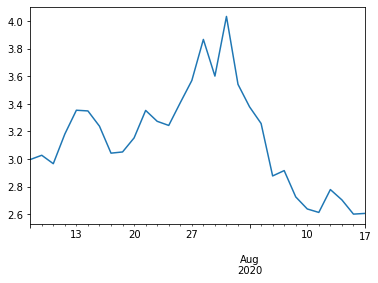

In [200]:
fc_all['expected_stuff'].plot()

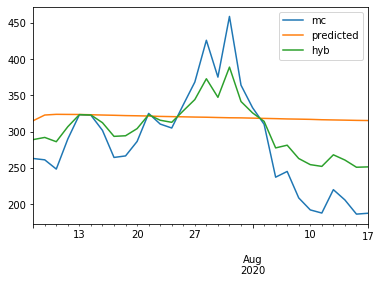

In [201]:
fc_all[['mc', 'predicted', 'hyb']].plot()

In [202]:
print(df['call_per_staff'][-30:].mean())

122.725


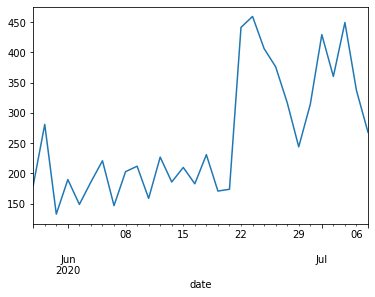

In [203]:
df['total'][-30:].plot()

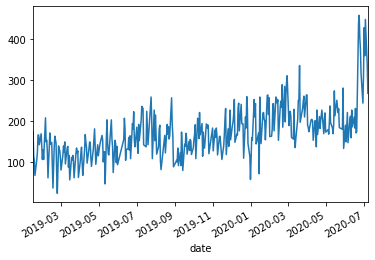

In [204]:
df['total'][-365:].plot()